# Q learning algorithm

In [1]:
import gym
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple


Declare hyperparameters for model training. They were set the same as in the SARSA tutorial except batch and update_steps.

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
GAMMA = 0.99
BATCH = 4
LR = 0.001
EPSILON_DECAY_RATE = 0.9999
UPDATE_STEPS = 4

#### batch & update_steps
In order to train the model stably, we can use mini batch. However, there might be a side effect of slowing the convergence speed due to poor sample efficiency. Since Q learning is an off policy method, we can solve this problem by doing multiple gradient updates on each data. <br />
If we use q table to approximate the q function, the specific q(s,a) value in the trajectory is updated to its target at once. However, in this example, since we use q network which is updated by loss function, multiple updates can accelerate the convergence of the network. <br /> 
If you want to increase the batch size, it is recommended to increase the update_steps equally to make the extent of epsilon decay the same.

#### gamma
The cartpole environment gives a reward of +1 every time before the stick collapses. Therefore, if gamma is set to 1, the value of the q function is diverged, so the q network cannot be trained theoretically (In fact, even if gamma is 1, it is possible to search for an optimal policy to some extent). In order to accurately get the q function when gamma is 1, note that the maximum time steps of one episode is 500 in the cartpole-v1 environment. Using this, we can make a neural network whose input states include time. In this tutorial, to simplify the problem, only the state condition basically given in the cartpole environment was used.

### Building Q network using PyTorch

First we build q network, which approximates the q function in the Cartpole environment, and create a Q learning class that performs model training and agent behavior.

In [3]:
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(obs_size, 32)
        self.fc2 = nn.Linear(32,32)
        self.fc3 = nn.Linear(32,32)
        self.fc4 = nn.Linear(32, act_size)

    def forward(self, s):
        q = F.relu(self.fc1(s))
        q = F.relu(self.fc2(q))
        q = F.relu(self.fc3(q))
        q = self.fc4(q)

        return q


class QLearning():
    def __init__(self, q_network, epsilon = 1):
        self.net = q_network
        self.epsilon = epsilon
        self.min_epsilon = 0.01
        self.transition = namedtuple("Transition" , ['s', 'a', 'r', 's_', 'd'])
        self.buffer = []
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), LR)
        
    def get_action(self, s):
        s_tensor = (torch.from_numpy(s)).float().to(DEVICE) 

        # epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            a = np.random.randint(act_size)
        else:
            q = self.net(s_tensor).detach()
            a = torch.argmax(q).item()
        return a
    
    def stack_buffer(self, sample):
        self.buffer.append(self.transition(*sample))

    def update(self):
        s = torch.tensor([e.s for e in self.buffer]).reshape(BATCH, obs_size).float().to(DEVICE)
        a = torch.tensor([e.a for e in self.buffer]).reshape(BATCH, 1).long().to(DEVICE) 
        r = torch.tensor([e.r for e in self.buffer]).reshape(BATCH, 1).float().to(DEVICE)
        s_ = torch.tensor([e.s_ for e in self.buffer]).reshape(BATCH, obs_size).float().to(DEVICE)
        d = torch.tensor([e.d for e in self.buffer]).reshape(BATCH, 1).float().to(DEVICE)
        self.buffer.clear()
        for num in range(UPDATE_STEPS):
            self.epsilon = max(self.min_epsilon, self.epsilon * EPSILON_DECAY_RATE)
            
            q_all = self.net(s)
            q = torch.gather(q_all, 1, a)
            q_all_ = self.net(s_)
            q_ = torch.max(q_all_, axis=1, keepdim=True).values 
            target = (r + (1-d) * GAMMA * q_).detach()
            # TD_error = target - q
            loss = self.criterion(q, target)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return loss.detach().cpu().numpy()

### Visualization of training

Next, to visualize the training, we define a class that draws a loss function and cumulative rewards as training progresses.

In [4]:
 class Graph():
    def __init__(self):
        self.max_num_data = 200
        
        self.fig, self.ax = plt.subplots(1, 2, figsize=(12, 4))
        self.loss_graph, = self.ax[0].plot(1)
        self.reward_graph, = self.ax[1].plot(1)

        self.ax[0].set_title("Loss")
        self.ax[0].set_xlim(0,1)
        self.ax[0].set_ylim(0,2)
        self.ax[0].set_yscale('log')
        self.ax[0].set_xlabel('step')
        self.ax[0].set_ylabel('loss')

        self.ax[1].set_title("Cumulative reward")
        self.ax[1].set_xlim(0,10)
        self.ax[1].set_ylim(0,2)
        self.ax[1].set_xlabel('episode')
        self.ax[1].set_ylabel('reward')

    
    def update_loss(self, loss_list):
        while len(loss_list) > self.max_num_data:
            loss_list = [data for idx, data in enumerate(loss_list) if idx %2 == 0]
        
        x = [i[0] for i in loss_list]
        y = [i[1] for i in loss_list]
        
        self.ax[0].set_xlim(0,x[-1])
        self.ax[0].set_ylim(np.min(y)*0.9,np.max(y)*1.1)

        self.loss_graph.set_xdata(x)
        self.loss_graph.set_ydata(y)        

        self.fig.canvas.draw()
        self.fig.canvas.flush_events()     
        
    def update_reward(self, reward_list):
        while len(reward_list) > self.max_num_data:
            reward_list = [data for idx, data in enumerate(reward_list) if idx %2 == 0]
        
        x = [i[0] for i in reward_list]
        y = [i[1] for i in reward_list]
        
        self.ax[1].set_xlim(0,x[-1])
        self.ax[1].set_ylim(np.min(y)*0.9, np.max(y)*1.1)
        self.reward_graph.set_xdata(x)
        self.reward_graph.set_ydata(y)        

        self.fig.canvas.draw()
        self.fig.canvas.flush_events()    

### Training the model

Create an cartpole environment and instances of our Q learning model.

In [5]:
env = gym.make("CartPole-v1")
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
q_network = QNetwork().to(DEVICE)
agent = QLearning(q_network)

After setting the training related variables, execute the cartpole environment. Upon receiving the observation state from the environment, agent acts depending on the value of q calculated through the q network and the epsilon greedy policy. As a result, the agent gets a reward and moves on to the next state.

<IPython.core.display.Javascript object>


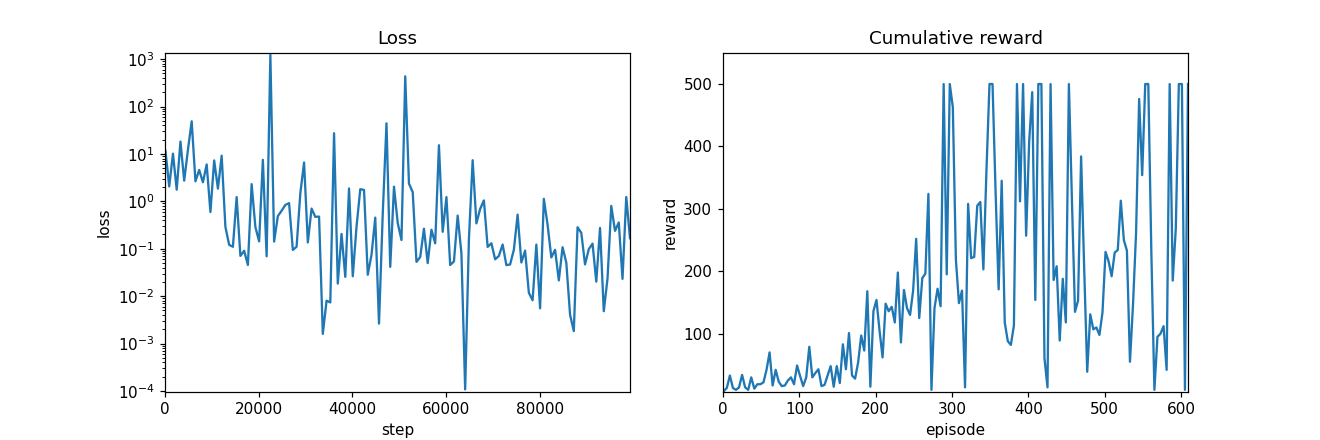

In [6]:
%matplotlib notebook
plt.ion()
graph = Graph()
loss_list = []
reward_list = []
loss_record_term = 100
max_steps = 100000
num_update = 0
episode = 0
step = 0
while step < max_steps:
    episode += 1
    cum_reward = 0
    state = env.reset()

    while True :
        step += 1
        env.render()
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        sample = [state, action, reward, next_state, done]
        agent.stack_buffer(sample)
        cum_reward += reward    
        
        state = next_state
        # update
        if len(agent.buffer) == BATCH:
            loss = agent.update()
            num_update += 1
        # record loss
        if step % loss_record_term == 0: 
            loss_list.append([step,loss])
            graph.update_loss(loss_list)
            #print("num_update, loss , epsilon : " ,num_update, loss, agent.epsilon)

        # terminated
        if done:
            reward_list.append([episode, cum_reward])
            graph.update_reward(reward_list)
            #print("episode: {}, total reward: {}".format(episode, cum_reward))
            break
env.close()

Save the trained model.

In [7]:
torch.save(q_network.state_dict(), "./qlearning_cartpole.pt")

### Test with trained model

Load the saved model and get ready to run.

In [8]:
# if applicable, initialize the instances again.
#env = gym.make("CartPole-v1")
#observation_size = env.observation_space.shape[0]
#action_size = env.action_space.n
#q_network = QNetwork(observation_size, action_size).to(DEVICE)

# load the trained q network
q_network.load_state_dict(torch.load("./qlearning_cartpole.pt"))
q_network.eval()
agent = QLearning(q_network, epsilon= 0)
agent.min_epsilon=0

Evaluate the trained Q learning model with greedy policy.

In [9]:
for episode in range(1, 5):
    cum_reward = 0
    state = env.reset()

    while True :
        env.render()
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        cum_reward += reward    
        
        state = next_state

        # terminated
        if done:
            print("episode: {}, total reward: {}".format(episode, cum_reward))
            break
env.close()

episode: 1, total reward: 500.0
episode: 2, total reward: 500.0
episode: 3, total reward: 500.0
episode: 4, total reward: 500.0
